In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from preprocess import process_cad_rads_labels, evaluate_performance, plot_confusion_matrix, compare_certainty

In [2]:
API = 'chatgpt'
# API = 'claude'
# API = 'gemini'

In [3]:
USE_COT = True
# USE_COT = False

# USE_CERTAINTY = True
USE_CERTAINTY = False

USE_MANYSHOT = True

MAX_OUTPUT_LENGTH = 1000 if USE_COT else 50

In [4]:

if API == 'chatgpt':
    from openai import OpenAI
    api_key = 'YOUR_API_KEY'
    client = OpenAI(api_key=api_key)

elif API == "claude":
    import anthropic
    api_key = 'YOUR_API_KEY'
    client = anthropic.Anthropic(api_key=api_key)

elif API == "gemini":
    import google.generativeai as genai
    api_key = 'YOUR_API_KEY'
    genai.configure(api_key=api_key)

print(API)

chatgpt


In [5]:
VERSION = 'v1.1'

data = pd.read_csv(f'sample_processed_internal_test_50_{VERSION}.csv')

data.fillna(value='None', inplace=True)

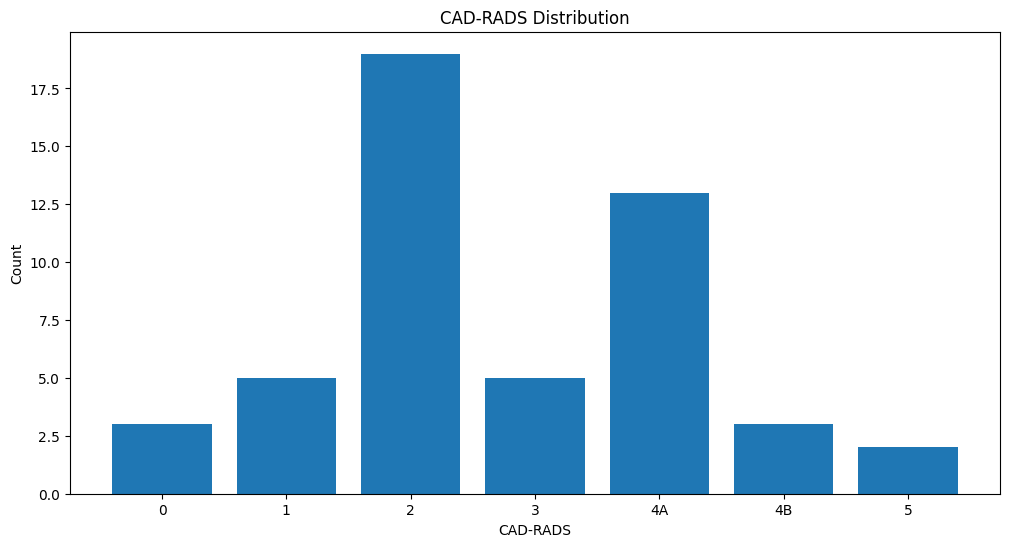

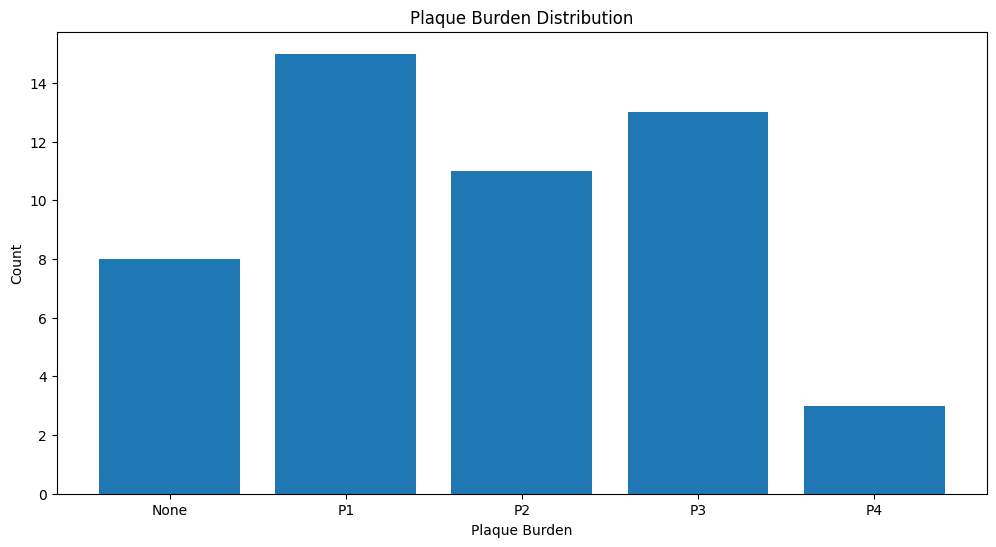

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# CAD-RADS 분포 그래프
plt.figure(figsize=(12, 6))
cad_rads_order = ['0', '1', '2', '3', '4A', '4B', '5']
cad_rads_counts = data['CAD-RADS'].value_counts().reindex(cad_rads_order).fillna(0)

plt.bar(cad_rads_counts.index, cad_rads_counts.values)
plt.title('CAD-RADS Distribution')
plt.xlabel('CAD-RADS')
plt.ylabel('Count')
plt.show()

# Plaque burden 분포 그래프
plt.figure(figsize=(12, 6))
plaque_burden_order = ['None', 'P1', 'P2', 'P3', 'P4']
plaque_burden_counts = data['Plaque Burden'].value_counts().reindex(plaque_burden_order).fillna(0)

plt.bar(plaque_burden_counts.index, plaque_burden_counts.values)
plt.title('Plaque Burden Distribution')
plt.xlabel('Plaque Burden')
plt.ylabel('Count')
plt.show()

In [7]:
if not USE_COT:
    # f = open("prompt_system.txt", 'r')
    # f = open("prompt_system_0612.txt", 'r')
    # f = open("prompt_system_0705.txt", 'r')
    # f = open("prompt_system_0828.txt", 'r')
    # f = open("prompt_system_0830.txt", 'r')
    f = open("prompt_system_1016.txt", 'r', encoding='utf-8')
elif USE_COT and not USE_CERTAINTY:
    # f = open("prompt_system_0828_cot.txt", 'r')
    # f = open("prompt_system_0829_cot.txt", 'r')
    # f = open("prompt_system_0830_cot.txt", 'r')
    # f = open("prompt_system_0913_cot.txt", 'r', encoding='utf-8')
    # f = open("prompt_system_0930_cot.txt", 'r', encoding='utf-8')
    f = open("prompt_system_1016_cot_edit.txt", 'r', encoding='utf-8')
elif USE_COT and USE_CERTAINTY:
    # f = open("prompt_system_0913_cot_certainty.txt", 'r', encoding='utf-8')
    # f = open("prompt_system_0930_cot_edit_certainty.txt", 'r', encoding='utf-8')
    # f = open("prompt_system_1014_cot_edit_certainty.txt", 'r', encoding='utf-8')
    f = open("prompt_system_1016_cot_edit_certainty.txt", 'r', encoding='utf-8')

prompt_sys = f.read()
f.close()
print(prompt_sys)


You need to extract the CAD-RADS, Plaque burden, and Modifier from a coronary artery CT report. Refer to the information below:

CAD-RADS
CAD-RADS is determined based on the most severe stenosis among various coronary branches:
- 0: 0%, Absence of CAD
- 1: 1-24%, Minimal non-obstructive CAD
- 2: 25-49%, Mild non-obstructive CAD (Mild stenosis)
- 3: 50-69%, Moderate stenosis
- 4A: 70-99% in a single or 2-vessel, Severe stenosis
- 4B: If the left main (LM) shows stenosis of 50% (moderate) or higher, or if 3-vessel(including LAD, LCx, RCA, OM, D, PDA) have stenosis of 70% (severe) or higher.
- 5: 100% Total coronary occlusion
 
Plaque Burden
Plaque Burden is determined by the overall amount of coronary plaque and Coronary artery calcium (CAC):
- None: 0
- P1: Mild, 1-100
- P2: Moderate, 101-300
- P3: Severe, 301-999
- P4: Extensive, >1000

Modifiers 
There are 6 modifiers that can be added to the CAD-RADS category. More than one modifiers can be applicable:
- N: If "Limited evaluation due

In [8]:
if not USE_COT:
    f = open("prompt_user_few.txt", 'r')

elif USE_COT and not USE_CERTAINTY:
    # f = open("prompt_user_few_cot.txt", 'r')
    if USE_MANYSHOT:
        f = open("prompt_user_few_cot_ManyShot.txt", 'r')
    else:
        f = open("prompt_user_few_cot_UpperEnd.txt", 'r')


elif USE_COT and USE_CERTAINTY:
    # f = open("prompt_user_few_cot_certainty.txt", 'r')
    f = open("prompt_user_few_cot_certainty_UpperEnd.txt", 'r')


prompt_user_few = f.read()
print(prompt_user_few)
f.close()


Extract the CAD-RADS, Plaque burden, and Modifier from a given coronary artery CT report like examples below.
===


In [9]:
if API=='gemini':
    client = genai.GenerativeModel(
        # model_name="gemini-1.5-flash",
        model_name="gemini-1.5-pro",
        generation_config={
            "temperature": 0,
            "max_output_tokens": MAX_OUTPUT_LENGTH,
            "response_mime_type": "text/plain",
            },
        system_instruction=prompt_sys
        )

In [10]:
def get_response(API, client, prompt_sys, prompt): 
  if API == 'chatgpt':
    response = client.chat.completions.create(
      model="gpt-4-turbo",
      # model="gpt-4o",
      messages=[
        {
          "role": "system",
          "content": [
            {
              "type": "text",
              "text": prompt_sys,
            }
          ]
        },
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            }
          ]
        }
      ],
      max_tokens=MAX_OUTPUT_LENGTH,
      temperature=0,

      # model="o1-mini",
      # messages=[
      #   {
      #     "role": "user",
      #     "content": [
      #       {
      #         "type": "text",
      #         "text": prompt_sys,
      #       }
      #     ]
      #   },
      #   {
      #     "role": "user",
      #     "content": [
      #       {
      #         "type": "text",
      #         "text": prompt
      #       }
      #     ]
      #   }
      # ],
      
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )

    return response.choices[0].message.content
  
  elif API == 'claude':
    response = client.messages.create(
      model="claude-3-5-sonnet-20240620",
      max_tokens=MAX_OUTPUT_LENGTH,
      temperature=0,
      system=prompt_sys,
      messages=[
          {
              "role": "user",
              "content": [
                  {
                      "type": "text",
                      "text": prompt
                  }
              ]
          }
      ]
    )
    return response.content[0].text

  elif API == 'gemini':
    chat_session = client.start_chat()
    response = chat_session.send_message(prompt)
    return response.text


In [11]:
if USE_COT:
    trigger = "Final Answer (CAD-RADS/Plaque Burden/Modifier):"
else:
    trigger = "CAD-RADS/Plaque Burden/Modifier: "

In [16]:
# manyshot_pool = pd.read_csv('manyshot_pool_from_claude.csv')
manyshot_pool = pd.read_csv('manyshot_pool_all_from_claude.csv')

In [13]:
def make_many_shot_prompt(base_prompt, report, shots):
    """
    Create a prompt with n-shot examples
    
    Args:
        n (int): Number of shots to include
        report (str): The target report to classify
        shots (list): List of dictionaries containing shot examples with 'Report' and '0' columns
        
    Returns:
        str: Formatted prompt with shots
    """
    prompt = ""
    for i, shot in enumerate(shots):
        prompt += f'Example {i+1}:\n\n' + f"### Report:\n{shot['Report']}\n\n"
        prompt += f"### Rationale: \n{shot['0']}\n===\n"
    
    prompt += f"""Now, extract the information from following report in the same format:

### Report: \n{report}\n\n### Rationale:\n"""
    
    prompt = base_prompt + '\n' + prompt
    return prompt

In [14]:
responses = []
labels = []
# for i in tqdm(range(3,5)):
for i in tqdm(range(len(data))):
    if USE_MANYSHOT:
        sampled_shots = manyshot_pool.sample(n=100)[['Report', '0']].to_dict('records')

        # Create prompt using the sampled shots
        prompt = make_many_shot_prompt(
            prompt_user_few,
            report=data['Report'][i],
            shots=sampled_shots
        )
    else:
        prompt = prompt_user_few + '\n' + data['Report'][i] #+ "\n\n### CAD-RADS/Plaque Burden/Modifier: "

    response = get_response(API, client, prompt_sys, prompt)

    if trigger in response:
        responses.append(response)
    else:
        print(f'Response {i} does not contain the final answer. Retrying.')
        print(response)
        new_response = get_response(API, client, prompt_sys, prompt + "\n\n### Rationale:\n" + response + "\n\n" + trigger)
        responses.append(response + "\n\n" + trigger + new_response)

  0%|          | 0/50 [00:00<?, ?it/s]


ValueError: Cannot take a larger sample than population when 'replace=False'

In [75]:
labels = [r.split(trigger)[-1].split('\n')[0] for r in responses]
labels = pd.DataFrame(labels)
responses = pd.DataFrame(responses)

In [76]:
import re

def process_data(data):
    certainty_cadrads = []
    certainty_plaque = []
    processed_strings = []

    for item in data:
        parts = item.split('/')
        
        # CAD-RADS Certainty 추출
        cadrads_match = re.search(r'\((\d+)\)', parts[0])
        if cadrads_match:
            certainty_cadrads.append(int(cadrads_match.group(1)))
        
        # Plaque Certainty 추출
        plaque_match = re.search(r'\((\d+)\)', parts[1])
        if plaque_match:
            certainty_plaque.append(int(plaque_match.group(1)))
        
        # 괄호와 내용 제거
        processed_item = '/'.join([re.sub(r'\([^)]*\)', '', part).strip() for part in parts])
        processed_strings.append(processed_item)
    
    return certainty_cadrads, certainty_plaque, processed_strings

In [77]:
if USE_CERTAINTY:
    certainty_cadrads, certainty_plaque, processed_strings = process_data(list(labels[0]))
    labels = pd.DataFrame(processed_strings)

In [78]:
labels = process_cad_rads_labels(labels,0)

In [79]:
if USE_CERTAINTY:
    labels['certainty_cadrads'] = certainty_cadrads
    labels['certainty_plaque'] = certainty_plaque

In [80]:
# TAG = "CoT_edit_GPT4"
# TAG = "CoT_edit_certainty_UpperEnd"
# TAG = "CoT_certainty_GPT4"
# TAG = "o1-mini"
# TAG = "CoT"
# TAG = "CoT_GPT4"
# TAG = "CoT_certainty_o1-mini"
# TAG = "CoT_GPT4_Shot20"
TAG = "CoT_GPT4_Shot50"
# TAG = ""

filename = f'result_1028_{API}_InterTest_{VERSION}_{TAG}.xlsx'
print(filename)
pd.concat([data, labels, responses], axis=1).to_excel(filename)

result_1028_chatgpt_InterTest_v1.1_CoT_GPT4_Shot50.xlsx


# GPT4

In [134]:
labels = data.iloc[:,4:]

# pred = pd.read_excel('result_1014_chatgpt_InterTest_v1.0_CoT_edit_certainty.xlsx')
# pred = pd.read_excel('result_1014_chatgpt_InterTest_v1.0_CoT_edit_certainty_UpperEnd.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_CoT_edit_certainty_UpperEnd.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_CoT_certainty_GPT4.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_CoT_certainty_o1-mini.xlsx')
# pred = pd.read_excel('result_1021_chatgpt_InterTest_v1.1_CoT_edit_certainty_UpperEnd.xlsx')
# certainty = pred[['certainty_cadrads', 'certainty_plaque']]
# pred = pred.iloc[:,-11:-3]

# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_o1-mini.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_CoT.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_CoT_GPT4.xlsx')
# pred = pd.read_excel('result_1016_chatgpt_InterTest_v1.1_CoT_o1-mini.xlsx')
pred = pd.read_excel('result_1028_chatgpt_InterTest_v1.1_CoT_GPT4_Shot20.xlsx')
# pred = pd.read_excel('result_1028_chatgpt_InterTest_v1.1_CoT_GPT4_Shot50.xlsx')
pred = pred.iloc[:, -9:-1]

# 모든 컬럼 이름에서 '.1' 제거
pred.columns = pred.columns.str.replace('.1', '')
pred = pred[labels.iloc[:,:-1].columns]

C:\Users\User\AppData\Local\Temp\ipykernel_286140\1057495082.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')


In [133]:
pred.loc[40, 'CAD-RADS']='2'
pred.loc[40, 'Plaque Burden']='P1'
pred.loc[40, 'S']=1
pred.loc[40, 'HRP']=1

pred.loc[41, 'CAD-RADS']='4A'
pred.loc[41, 'Plaque Burden']='0'
pred.loc[41, 'G']=1

CAD-RADS Metrics:
Accuracy: 85.71%
F1 Score: 0.8317


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


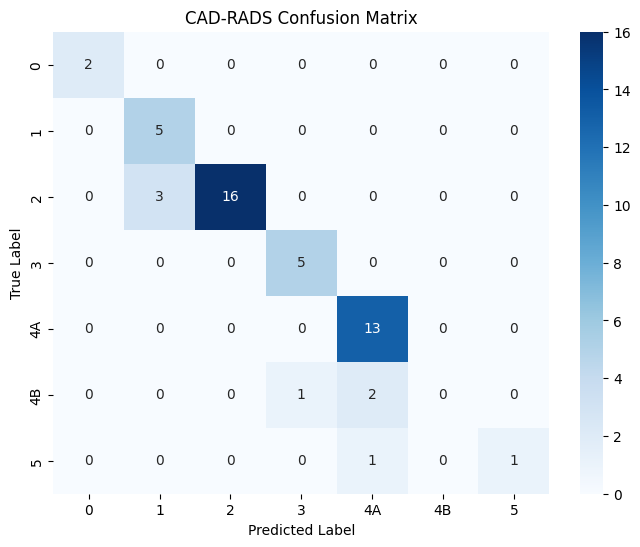

Plaque Burden Metrics:
Accuracy: 97.67%
F1 Score: 0.9768


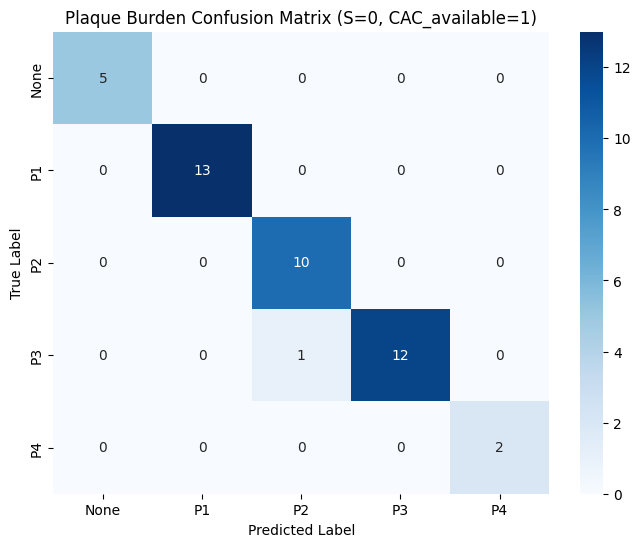

E Metrics:
Accuracy: 98.0%
F1 Score: 0.9701


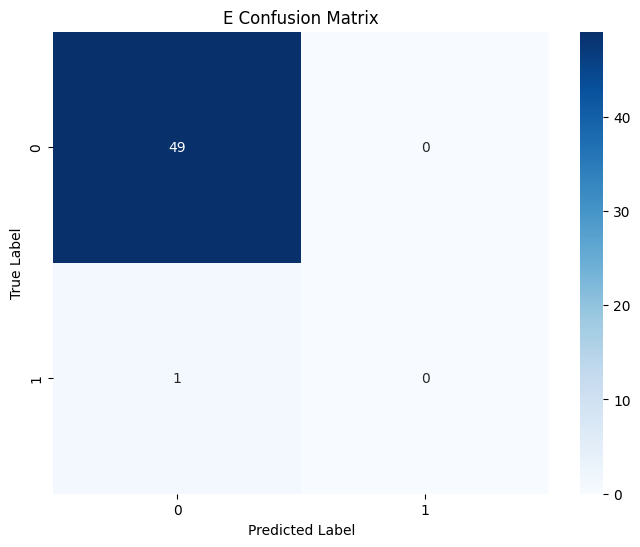

N Metrics:
Accuracy: 100.0%
F1 Score: 1.0


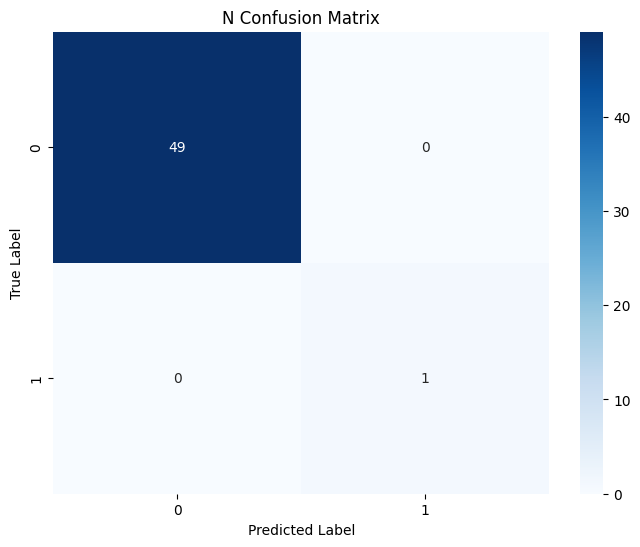

S Metrics:
Accuracy: 100.0%
F1 Score: 1.0


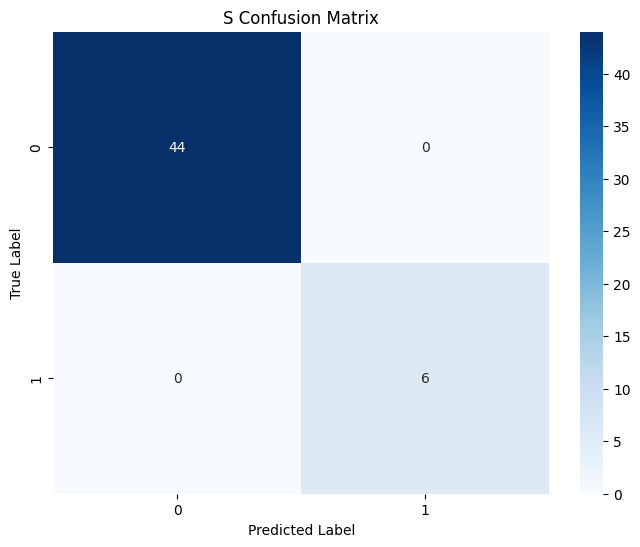

I Metrics:
Accuracy: 100.0%
F1 Score: 1.0


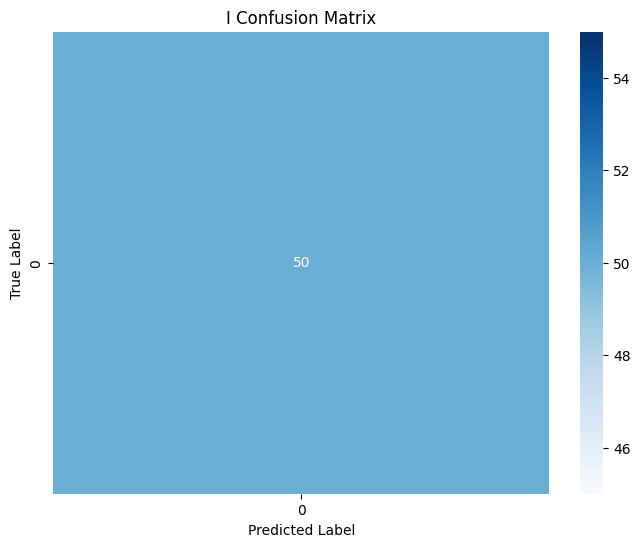

G Metrics:
Accuracy: 100.0%
F1 Score: 1.0


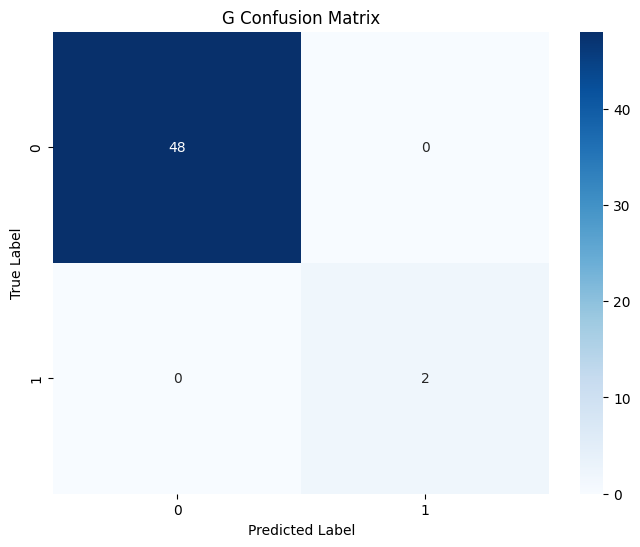

HRP Metrics:
Accuracy: 100.0%
F1 Score: 1.0


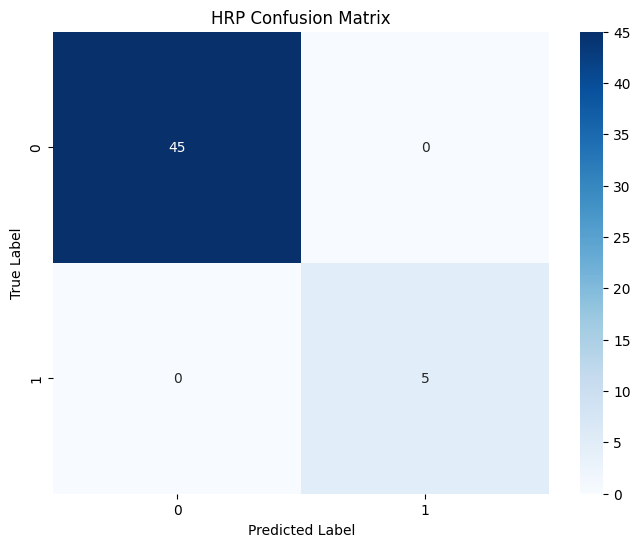

In [135]:
# 성능 평가 및 플롯 실행
performance_metrics = evaluate_performance(labels, pred)
for key, value in performance_metrics.items():
    print(f"{key} Metrics:")
    print(f"Accuracy: {round(value['Accuracy']*100,2)}%")
    print(f"F1 Score: {round(value['F1 Score'], 4)}")
    # print(f"Confusion Matrix:\n{value['Confusion Matrix']}\n")
    # 혼동 행렬 플롯
    if key in ['CAD-RADS', 'HRP', 'E', 'G', 'N', 'I', 'S']:
        class_labels = np.unique(np.concatenate((pred[key].dropna(), labels[key].dropna())))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix')
    elif key == 'Plaque Burden':
        # S가 0이고 CAC_available이 1인 경우만 선택
        mask = (labels['S'] == 0) & (labels['CAC_available'] == 1)
        plaque_data = pred[key][mask].dropna()
        plaque_labels = labels[key][mask].dropna()
        class_labels = np.unique(np.concatenate((plaque_data, plaque_labels)))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix (S=0, CAC_available=1)')

In [ ]:
certainty_comparison = compare_certainty(labels, pred, certainty)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
# 결과 출력
for category, values in certainty_comparison.items():
    print(f"\n{category}:")
    print(f"  Correct predictions:")
    print(f"    Average: {values['Avg Certainty (Correct)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Correct)']:.4f}")
    print(f"  Incorrect predictions:")
    print(f"    Average: {values['Avg Certainty (Incorrect)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Incorrect)']:.4f}")
    print(f"  Difference in averages: {values['Difference']:.4f}")
    print(f"  T-statistic: {values['t-statistic']:.4f}")
    print(f"  P-value: {values['p-value']:.4f}")
    print(f"  Statistical Significance: {'Significant' if values['p-value'] < 0.05 else 'Not Significant'}")


CAD-RADS:
  Correct predictions:
    Average: 9.0833
    Std Dev: 0.2803
  Incorrect predictions:
    Average: 9.0000
    Std Dev: 0.0000
  Difference in averages: 0.0833
  T-statistic: 1.0647
  P-value: 0.2925
  Statistical Significance: Not Significant

Plaque Burden:
  Correct predictions:
    Average: 10.0000
    Std Dev: 0.0000
  Incorrect predictions:
    Average: nan
    Std Dev: nan
  Difference in averages: nan
  T-statistic: nan
  P-value: nan
  Statistical Significance: Not Significant


# Claude3.5 sonnet

In [21]:
labels = data.iloc[:,4:]

# pred = pd.read_excel('result_0814_claude_v4.2.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.3_.xlsx')
# pred = pd.read_excel('result_0828_claude_v4.3_CoT.xlsx')
# pred = pred.iloc[:,-8:]

# pred = pd.read_excel('result_0829_claude_v4.3_CoT.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT_x_after_answer.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT_x_after_answer_x_none.xlsx')
# pred = pd.read_excel('result_0913_claude_v4.4_CoT_x_after_answer_x_none.xlsx')
# pred = pd.read_excel('result_0930_claude_v4.5_CoT.xlsx')
# pred = pd.read_excel('result_0930_claude_v4.5_CoT_edit.xlsx')
# pred = pred.iloc[:,-9:-1]

pred = pd.read_excel('result_0930_claude_v4.5_CoT_edit_certainty.xlsx')
certainty = pred[['certainty_cadrads', 'certainty_plaque']]
pred = pred.iloc[:,-11:-3]

# 모든 컬럼 이름에서 '.1' 제거
pred.columns = pred.columns.str.replace('.1', '')
pred = pred[labels.iloc[:,:-1].columns]

C:\Users\User\AppData\Local\Temp\ipykernel_135748\2483507845.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


CAD-RADS Metrics:
Accuracy: 93.81%
F1 Score: 0.9211


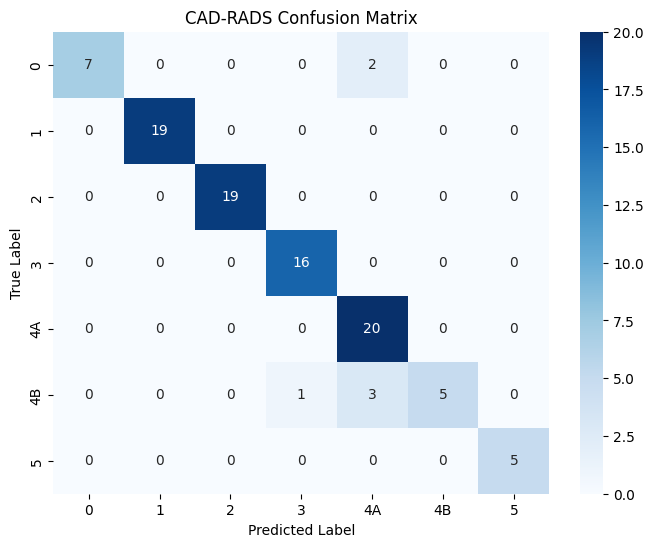

Plaque Burden Metrics:
Accuracy: 100.0%
F1 Score: 1.0


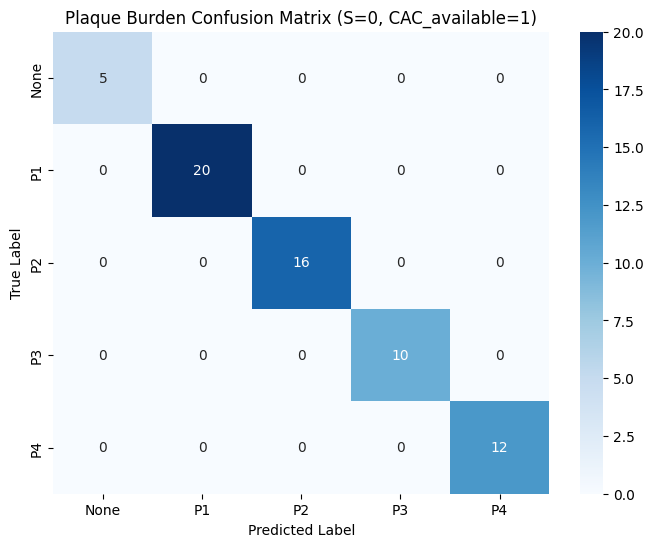

S Metrics:
Accuracy: 98.97%
F1 Score: 0.9753


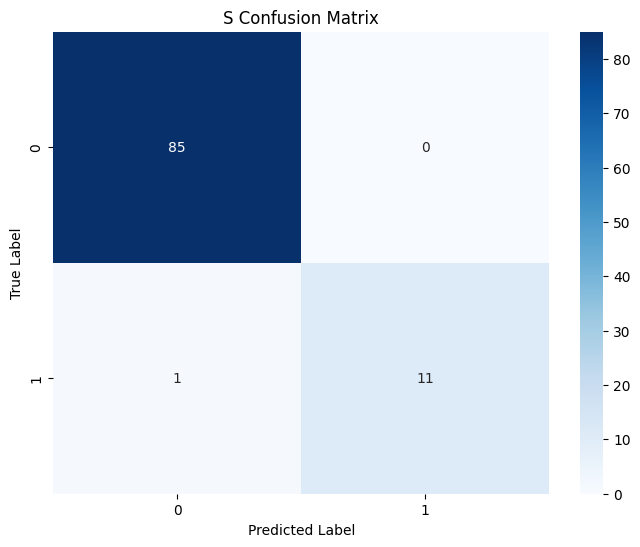

HRP Metrics:
Accuracy: 100.0%
F1 Score: 1.0


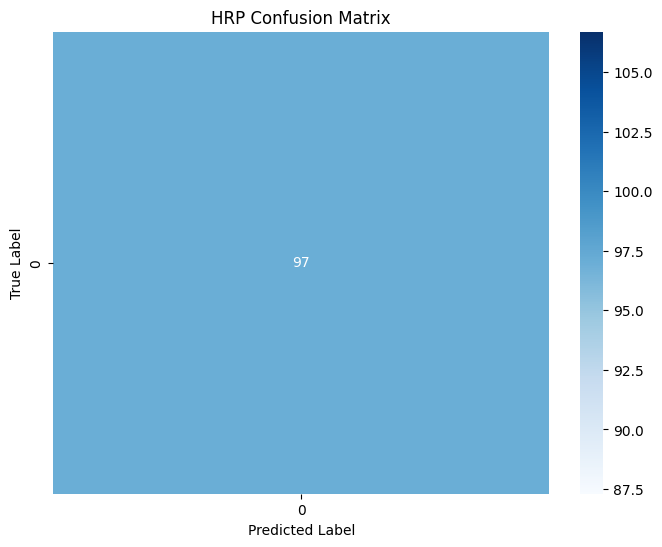

G Metrics:
Accuracy: 98.97%
F1 Score: 0.9708


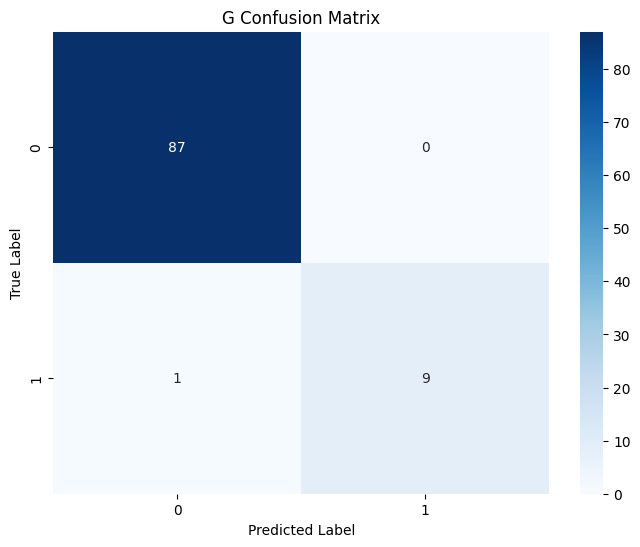

N Metrics:
Accuracy: 96.91%
F1 Score: 0.9392


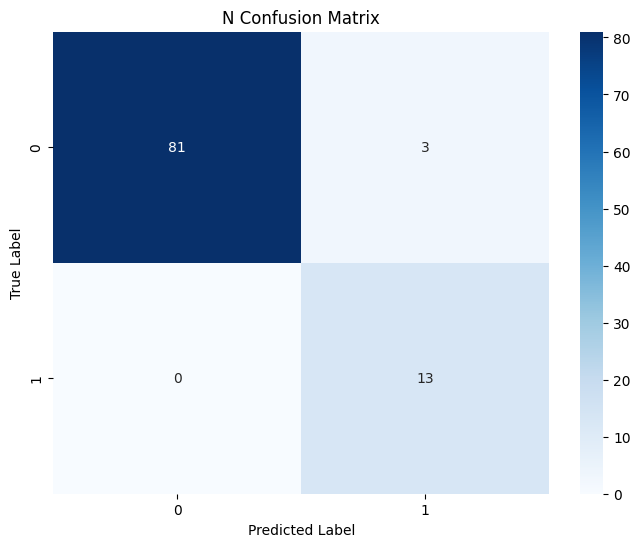

I Metrics:
Accuracy: 100.0%
F1 Score: 1.0


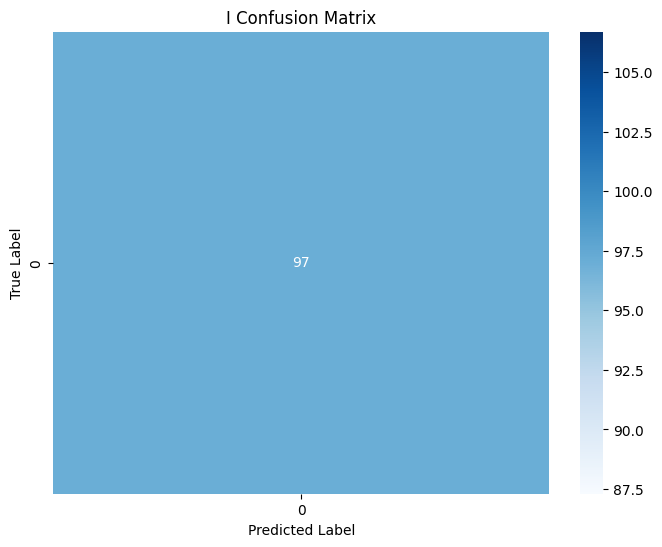

E Metrics:
Accuracy: 98.97%
F1 Score: 0.8307


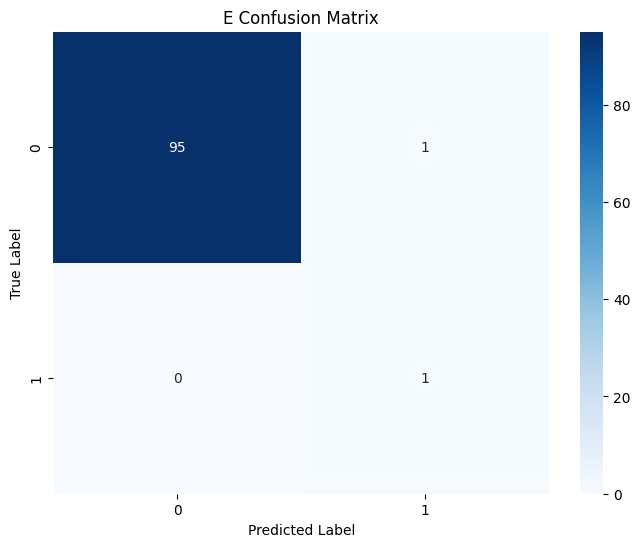

In [22]:
# 성능 평가 및 플롯 실행
performance_metrics = evaluate_performance(labels.iloc[3:], pred.iloc[3:])
for key, value in performance_metrics.items():
    print(f"{key} Metrics:")
    print(f"Accuracy: {round(value['Accuracy']*100,2)}%")
    print(f"F1 Score: {round(value['F1 Score'], 4)}")
    # print(f"Confusion Matrix:\n{value['Confusion Matrix']}\n")
    # 혼동 행렬 플롯
    if key in ['CAD-RADS', 'HRP', 'E', 'G', 'N', 'I', 'S']:
        class_labels = np.unique(np.concatenate((pred[key].dropna(), labels[key].dropna())))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix')
    elif key == 'Plaque Burden':
        # S가 0이고 CAC_available이 1인 경우만 선택
        mask = (labels['S'].iloc[3:] == 0) & (labels['CAC_available'].iloc[3:] == 1)
        plaque_data = pred[key].iloc[3:][mask].dropna()
        plaque_labels = labels[key].iloc[3:][mask].dropna()
        class_labels = np.unique(np.concatenate((plaque_data, plaque_labels)))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix (S=0, CAC_available=1)')

In [23]:
certainty_comparison = compare_certainty(labels, pred, certainty)

In [25]:
# 결과 출력
for category, values in certainty_comparison.items():
    print(f"\n{category}:")
    print(f"  Correct predictions:")
    print(f"    Average: {values['Avg Certainty (Correct)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Correct)']:.4f}")
    print(f"  Incorrect predictions:")
    print(f"    Average: {values['Avg Certainty (Incorrect)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Incorrect)']:.4f}")
    print(f"  Difference in averages: {values['Difference']:.4f}")
    print(f"  T-statistic: {values['t-statistic']:.4f}")
    print(f"  P-value: {values['p-value']:.4f}")
    print(f"  Statistical Significance: {'Significant' if values['p-value'] < 0.05 else 'Not Significant'}")


CAD-RADS:
  Correct predictions:
    Average: 8.9890
    Std Dev: 0.6582
  Incorrect predictions:
    Average: 8.0000
    Std Dev: 0.6325
  Difference in averages: 0.9890
  T-statistic: 3.5722
  P-value: 0.0006
  Statistical Significance: Significant

Plaque Burden:
  Correct predictions:
    Average: 9.9524
    Std Dev: 0.3780
  Incorrect predictions:
    Average: 8.2647
    Std Dev: 1.6571
  Difference in averages: 1.6877
  T-statistic: 7.7503
  P-value: 0.0000
  Statistical Significance: Significant


# Gemini

In [21]:
labels = data.iloc[:,4:]

# pred = pd.read_excel('result_0814_claude_v4.2.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.3_.xlsx')
# pred = pd.read_excel('result_0828_claude_v4.3_CoT.xlsx')
# pred = pred.iloc[:,-8:]

# pred = pd.read_excel('result_0829_claude_v4.3_CoT.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT.xlsx')
# pred = pd.read_excel('result_0829_claude_v4.4_CoT_x_after_answer.xlsx')
# pred = pd.read_excel('result_0829_gemini_v4.4_CoT_x_after_answer_x_none.xlsx')
# pred = pd.read_excel('result_0913_gemini_v4.4_CoT_x_after_answer_x_none.xlsx')
# pred = pd.read_excel('result_0930_gemini_v4.5_CoT_edit.xlsx')
# pred = pred.iloc[:,-9:-1]

pred = pd.read_excel('result_0930_gemini_v4.5_CoT_edit_certainty.xlsx')
certainty = pred[['certainty_cadrads', 'certainty_plaque']]
pred = pred.iloc[:,-11:-3]

# 모든 컬럼 이름에서 '.1' 제거
pred.columns = pred.columns.str.replace('.1', '')
pred = pred[labels.iloc[:,:-1].columns]
pred.loc[pred['CAD-RADS']=='4', 'CAD-RADS']='4A'

C:\Users\User\AppData\Local\Temp\ipykernel_125100\1464712226.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


CAD-RADS Metrics:
Accuracy: 86.6%
F1 Score: 0.8425


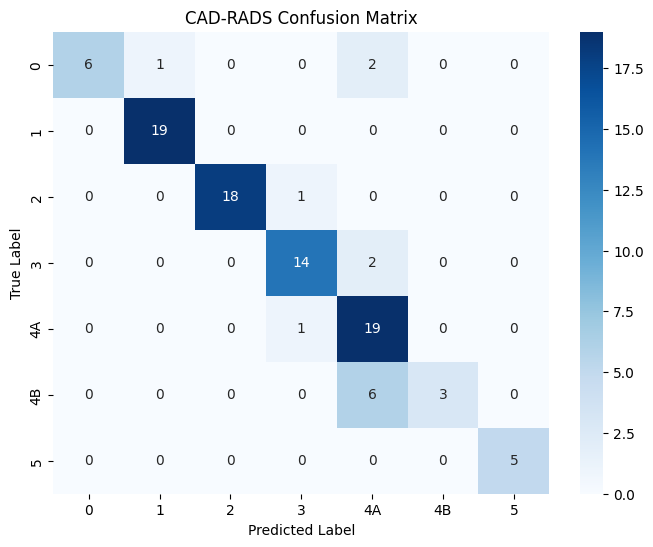

Plaque Burden Metrics:
Accuracy: 95.24%
F1 Score: 0.9467


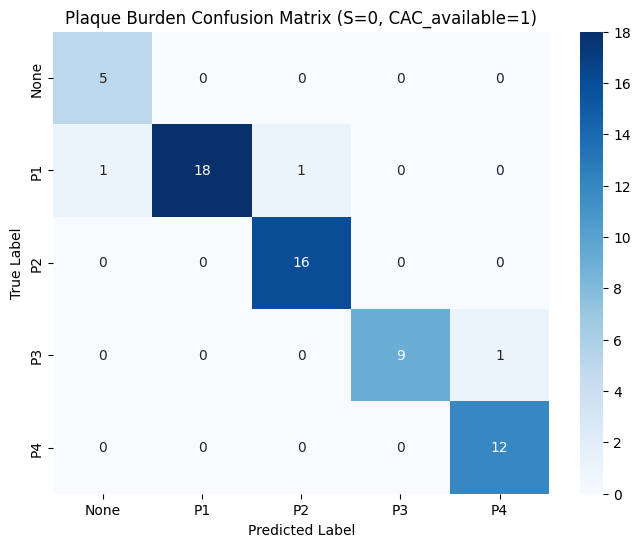

S Metrics:
Accuracy: 95.88%
F1 Score: 0.8885


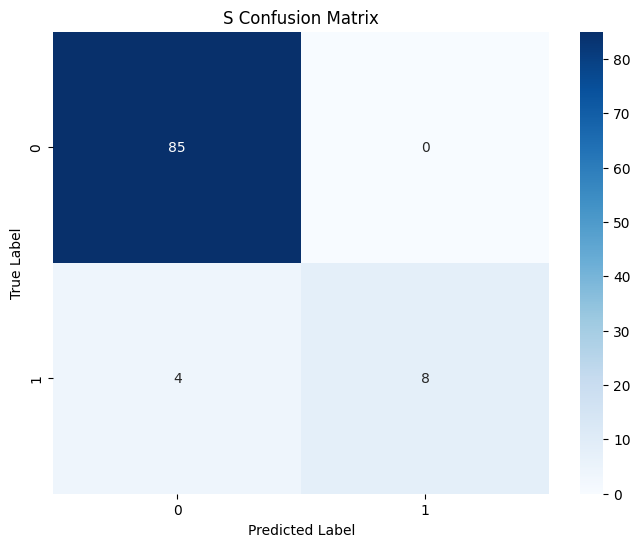

HRP Metrics:
Accuracy: 95.88%
F1 Score: 0.4895


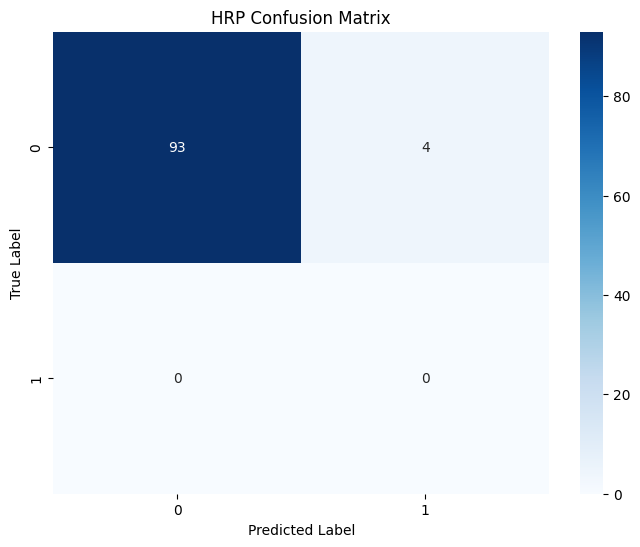

G Metrics:
Accuracy: 98.97%
F1 Score: 0.9708


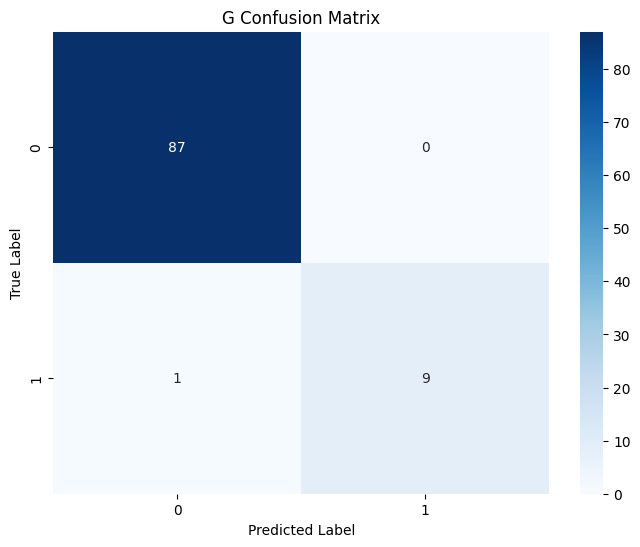

N Metrics:
Accuracy: 92.78%
F1 Score: 0.8393


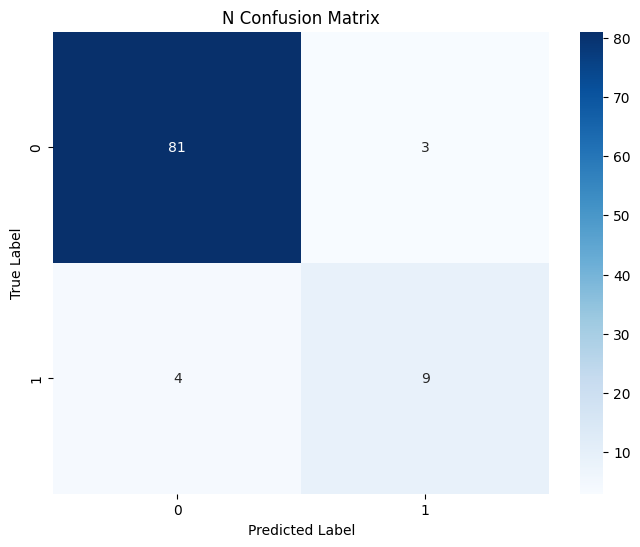

I Metrics:
Accuracy: 100.0%
F1 Score: 1.0


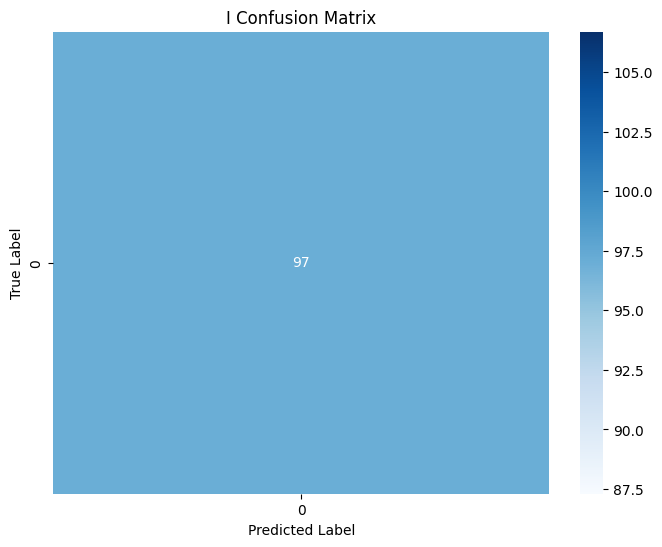

E Metrics:
Accuracy: 100.0%
F1 Score: 1.0


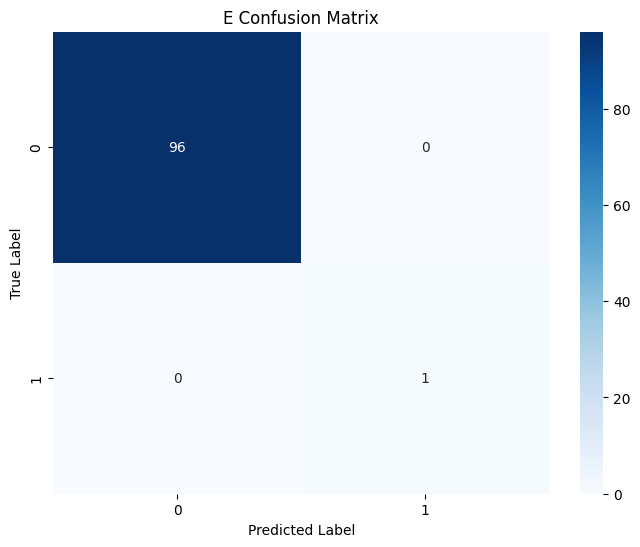

In [28]:
# 성능 평가 및 플롯 실행
performance_metrics = evaluate_performance(labels.iloc[3:], pred.iloc[3:])
for key, value in performance_metrics.items():
    print(f"{key} Metrics:")
    print(f"Accuracy: {round(value['Accuracy']*100,2)}%")
    print(f"F1 Score: {round(value['F1 Score'], 4)}")
    # print(f"Confusion Matrix:\n{value['Confusion Matrix']}\n")
    # 혼동 행렬 플롯
    if key in ['CAD-RADS', 'HRP', 'E', 'G', 'N', 'I', 'S']:
        class_labels = np.unique(np.concatenate((pred[key].dropna(), labels[key].dropna())))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix')
    elif key == 'Plaque Burden':
        # S가 0이고 CAC_available이 1인 경우만 선택
        mask = (labels['S'].iloc[3:] == 0) & (labels['CAC_available'].iloc[3:] == 1)
        plaque_data = pred[key].iloc[3:][mask].dropna()
        plaque_labels = labels[key].iloc[3:][mask].dropna()
        class_labels = np.unique(np.concatenate((plaque_data, plaque_labels)))
        plot_confusion_matrix(value['Confusion Matrix'], class_labels, title=f'{key} Confusion Matrix (S=0, CAC_available=1)')

In [23]:
certainty_comparison = compare_certainty(labels, pred, certainty)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [25]:
# 결과 출력
for category, values in certainty_comparison.items():
    print(f"\n{category}:")
    print(f"  Correct predictions:")
    print(f"    Average: {values['Avg Certainty (Correct)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Correct)']:.4f}")
    print(f"  Incorrect predictions:")
    print(f"    Average: {values['Avg Certainty (Incorrect)']:.4f}")
    print(f"    Std Dev: {values['Std Certainty (Incorrect)']:.4f}")
    print(f"  Difference in averages: {values['Difference']:.4f}")
    print(f"  T-statistic: {values['t-statistic']:.4f}")
    print(f"  P-value: {values['p-value']:.4f}")
    print(f"  Statistical Significance: {'Significant' if values['p-value'] < 0.05 else 'Not Significant'}")


CAD-RADS:
  Correct predictions:
    Average: 9.0000
    Std Dev: 1.0060
  Incorrect predictions:
    Average: 8.3077
    Std Dev: 1.3156
  Difference in averages: 0.6923
  T-statistic: 2.2119
  P-value: 0.0294
  Statistical Significance: Significant

Plaque Burden:
  Correct predictions:
    Average: 10.0000
    Std Dev: 0.0000
  Incorrect predictions:
    Average: 7.9459
    Std Dev: 2.1467
  Difference in averages: 2.0541
  T-statistic: 7.4362
  P-value: 0.0000
  Statistical Significance: Significant
